In [147]:
import pandas as pd
import numpy as np
import mne
import scipy.io as spio
from scipy.signal import butter, lfilter
import pickle
import os
import matplotlib.pyplot as plt
import keyboard
from IPython.display import clear_output
from functools import wraps
import warnings
%matplotlib inline

warnings.filterwarnings("ignore",category=DeprecationWarning)
directory = 'C:/Users/cfcoo/OneDrive - Ulster University/Study_3'

In [148]:
"""
Decorators
"""
def timer(orig_func):
    """
    decorator for logging time of function.
    """
    import time
    
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, *kwargs)
        t2 = time.time() - t1
        print(f"{orig_func.__name__} ran in: {t2} seconds")
        return result
    
    return wrapper

def funcStartStop(orig_func):
    """
    decorator for marking start and end of function running.
    """
    
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        print("Beginning " '\033[1m' + f"{orig_func.__name__}" + '\033[0m' + " function ...")
        result = orig_func(*args, **kwargs)
        print("Finished " '\033[1m' + f"{orig_func.__name__}" + '\033[0m' + " function!")
        return result
    return wrapper


In [149]:
def basic_info(ch_names, montage):
    """
    Instantiate information required for mne.RawArray.
    64 EEG channels + 1 trigger
    """
    sfreq = 250
    ch_names.append("trig")
    channel_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 
                     'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 
                     'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                     'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                     'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','stim']
    
    line_freq = 50 
    return mne.create_info(ch_names, sfreq, channel_types,montage)

def labels_dict_and_list(classes):
    """
    input: empty pandas DataFrame with column headings
           corresponding to class labels
    output: labels_dict (dict): key=number, value=string
            key_list (list): list of classes
    """
    
    labels_dict = dict()
    key_list = []
    for n, label in enumerate(classes.columns):
        labels_dict[str(n+1)] = label

    for key in labels_dict:
        key_list.append(key)
    return labels_dict, key_list

def get_epoched_labels(epochs):
    """
    input (mne.Epochs object)
    output: np.array of associated class labels
    """
    class_labels = []
    for i in epochs.events:
        class_labels.append(i[2])
    return np.array(class_labels)

def save_pickle_and_mat(path, fname, file):
    """
    Function for saving EEG data as both pickle and .mat
    Input - path (str) - location for saving
          - fname (str) - name of saved file
          - file (dict) - data to be saved
          - key (str) - optional key for saving pickle
    """
    epochsArray = file.get_data()
    epochsLabels = get_epoched_labels(file)
    dataAndLabelsM = dict(EEG=epochsArray, labels=epochsLabels) #matlab data
    
    if not os.path.exists(path):
        print("Creating new results file...")
        os.makedirs(path)
        
    dataAndLabelsP = dict(EEG=file, labels=epochsLabels) #matlab data
    
    spio.savemat(f"{path}/{fname}.mat", dataAndLabelsM)
    save_as_pickle(f"{path}/{fname}", dataAndLabelsP)

import pickle
def save_as_pickle(fname, file):
    f = open(fname, 'wb')
    pickle.dump(file, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    
def load_pickle(fname, key):
    f = open(fname,'rb')
    file = pickle.load(f)[key]
    return file
    
"""
Functions
"""
@timer
def validate_channels(data):
    """
    function to plot all channels in EEG dataset.
    """
  
    ch_names = data.ch_names
    
    for i,s in enumerate(data.get_data()):
        fig = plt.figure(1, figsize=(14,7))
        plt.title(ch_names[i], fontsize=20, fontname='Arial')
        plt.plot(s)
        plt.show()

        userip = input("Accept Channel? y/n: ")
        if userip == 'n':
            data.drop_channels([ch_names[i]]) 
        else:
            pass
        clear_output()
    return data, data[:][0]

def remove_channel(data, channel):
    return data.drop_channels(channel)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

@timer
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

def save_removed_chans(l1, l2, saveFile):
    removed_chans = Diff(l1,l2)
    print(removed_chans)
    if removed_chans != None: 
        with open(saveFile, 'w') as f:
            for item in removed_chans:
                f.write("%s\n" % item)
                
def save_removed_trials(epochedEEG, events, saveFile):
    """
    saves labels of removed trials to a .txt file
    Input: - epochedEEG (mne.Epochs object)
           - events (list): contains all trial class labels before removal
           - saveFile (str): file location
    """
    rejected = []
    for i, d in enumerate(epochedEEG.__dict__['drop_log']):
        if d != []:
            print(events[i][2])
            rejected.append(events[i][2])
        
    if rejected != None: 
        with open(saveFile, 'w') as f:
            for item in rejected:
                f.write("%s\n" % item)
    return rejected

def categorise_and_save(path, epochedEEG, classes, categories):
    """
    Splits the data into pre-defined experimental categories.
    Input - path (str): folder location to save to
          - epochedEEG (mne.Epochs object): either before or after ICA
          - classes (list): int labels assigned to classes
          - categories (list): string labels for each category
    """
    
    labels_dict, key_list = labels_dict_and_list(classes)
    print(key_list)
    for category in categories:
        pop_list = []
        i = 0
        while i < 4:
            pop_list.append(key_list.pop(0))
            i += 1
        epochs = epochedEEG.__getitem__(pop_list)
        
        save_pickle_and_mat(path, f"{category}_EEG", epochs)

In [150]:
"""
Read in a montage positions file and create a montage with mne
"""
df = pd.read_csv(f"{directory}/Matlab/montage_info/64-chan-montage_rev1.txt",sep="\t")
df.drop(['index'], axis=1, inplace=True)
ch_names = df.label.tolist()
pos = np.asarray(df.values[:, 1:], dtype=np.float64)

montage = mne.channels.Montage(pos=pos,
                               ch_names=ch_names,
                               kind='standard_1005',
                               selection=df.index.values)

#montage.plot()
#mne.viz.plot_montage(montage)

In [151]:
subj = "02"
sess = 2
data = spio.loadmat(f"{directory}/Subject_Data/S{subj}/session_{sess}/EEG.mat")['EEG'] # EEG saved from combined_trigger.m
datauV = np.true_divide(data[:-1], 1e6) # convert from uV to V for MNE
data = np.vstack((datauV, data[-1]))
print(f"Raw data shape: {data.shape}")
info = basic_info(ch_names, montage)

(64, 1543582)
(1543582,)
Raw data shape: (65, 1543582)


In [152]:
%matplotlib 
EEG = mne.io.RawArray(data,info)

EEG.plot(n_channels=32, scalings='auto', title='Auto-scaled Data from arrays',
         show=True, block=True, color=dict(eeg='darkblue'), duration=15.0, clipping='clamp')

Using matplotlib backend: Qt5Agg
Creating RawArray with float64 data, n_channels=65, n_times=1543582
    Range : 0 ... 1543581 =      0.000 ...  6174.324 secs
Ready.


In [153]:
"""
Run through each channel and remove those that are noisy or flat -
Store a list of removed channel names.
"""
%matplotlib inline
mne_data, raw_array = validate_channels(EEG)
save_removed_chans(ch_names, mne_data.info['ch_names'], f"{directory}/Subject_Data/S{subj}/session_{sess}/removed_chans.txt")

validate_channels ran in: 67.13657402992249 seconds
['FTT7h']


In [154]:
"""
Bandpass filter the data between 1 and 40 Hz.
"""
fs = 250
events = mne.find_events(EEG, "trig") # find stim values in trigger channel
filtered_data = np.append(butter_bandpass_filter(mne_data.get_data()[:-1], 1, 40, 250, 5), [mne_data.get_data()[-1]], axis=0)
EEG = mne.io.RawArray(filtered_data,mne_data.info)

#####Average Referencing#####

EEG.set_eeg_reference('average', projection=True, ch_type='eeg') #check the specific algorithm used
epochedEEG = mne.Epochs(EEG, events, tmin=-1.0+1/fs, tmax=2.5, baseline=(-0.5, 0.0))
epochedEEG.apply_proj()

#####Save data as pickle and .mat files#####
save_pickle_and_mat(f"{directory}/Subject_Data/S{subj}/Session_{sess}/EpochedArrays-preICA/", 
                    "epochs-all", epochedEEG)

#####variables for saving categorised data#####
path = f"{directory}/Subject_Data/S{subj}/Session_{sess}/EpochedArrays-preICA/" #must be preICA folder
classes = pd.read_csv(f"{directory}/Matlab/classes.txt", sep=";")
categories = ["actionText","combsText","actionImage","combsImage","actionAudio","combsAudio"]

######split and store the post-ica data#####
categorise_and_save(path, epochedEEG, classes, categories)

1200 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
butter_bandpass_filter ran in: 2.1334292888641357 seconds
Creating RawArray with float64 data, n_channels=64, n_times=1543582
    Range : 0 ... 1543581 =      0.000 ...  6174.324 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
1200 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Projections have already been applied. Setting proj attribute to True.
Loading data for 1200 events and 876 original time points ...
0 bad epochs dropped
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
Loading data for 200 events and 876 original time points ...
Loadin

In [6]:
epochedEEG = load_pickle(f"{directory}/Subject_Data/S{subj}/Session_{sess}/epochs-all", "epochs")

In [156]:
"""
Trial Rejection
"""
%matplotlib
epochedEEG.plot(scalings='auto', n_channels=32).show()

Using matplotlib backend: Qt5Agg
Loading data for 222 events and 876 original time points ...
Loading data for 20 events and 876 original time points ...
Loading data for 20 events and 876 original time points ...
Loading data for 20 events and 876 original time points ...
Loading data for 20 events and 876 original time points ...
Loading data for 20 events and 876 original time points ...
Dropped 2 epochs
Channels marked as bad: []


In [157]:
rejected = save_removed_trials(epochedEEG, events, f"{directory}/Subject_Data/S{subj}/session_{sess}/removed_trials.txt")

9
3


In [158]:
"""
Perform ICA for artefact removal - Especially eyeblink artefacts
"""
from mne.preprocessing import ICA

picks = mne.pick_types(epochedEEG.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')

method = 'fastica'
n_components = 32
decim = 2 # we need sufficient statistics, not all time points -> saves time -> important for paper.
random_state = 46

ica = ICA(n_components=32, max_pca_components=None, method=method, random_state=random_state)

ica.fit(epochedEEG, picks=picks, decim=decim)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Loading data for 1198 events and 876 original time points ...
Selection by number: 32 components
Loading data for 1198 events and 876 original time points ...
Fitting ICA took 19.3s.


<ICA  |  epochs decomposition, fit (fastica): 524724 samples, 32 components, channels used: "eeg">

Loading data for 1198 events and 876 original time points ...


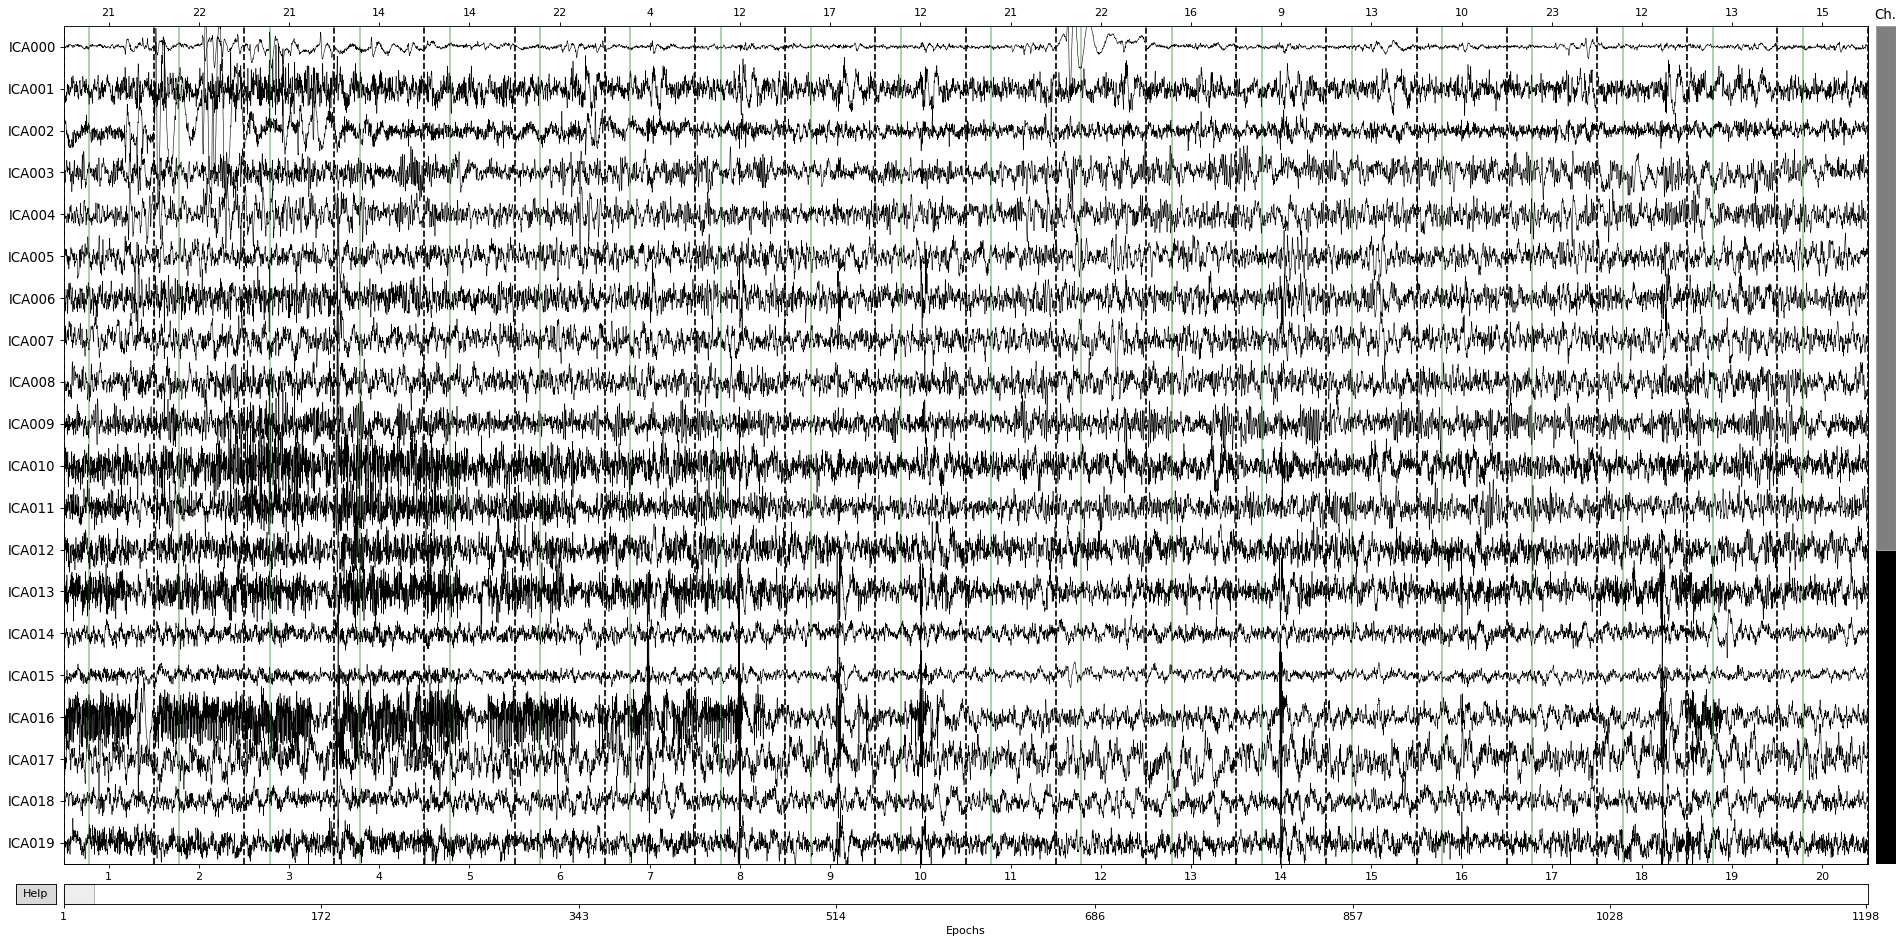

In [39]:
ica.plot_sources(epochedEEG) # view component timecourses

In [40]:
ica.plot_components() # show all components

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [33]:
ica.plot_properties(epochedEEG, picks=0) # View individual component characteristics

Loading data for 1197 events and 876 original time points ...
Loading data for 1197 events and 876 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
1197 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[<Figure size 504x432 with 6 Axes>]

In [159]:
"""
Select components to remove and plot comparison
"""
ica.exclude = [0]

reconstructEpochs = epochedEEG.copy()
ica.apply(reconstructEpochs.load_data())

epochedEEG.plot(scalings='auto', n_channels=32).show()
reconstructEpochs.plot(scalings='auto', n_channels=32).show()

Loading data for 1198 events and 876 original time points ...
Transforming to ICA space (32 components)
Zeroing out 1 ICA components


<Epochs  |   1198 events (all good), -1 - 2.5 sec, baseline [-0.5, 0], ~512.6 MB, data loaded,
 '1': 50
 '10': 50
 '11': 50
 '12': 50
 '13': 50
 '14': 50
 '15': 50
 '16': 50
 '17': 50
 '18': 50
 '19': 50
 '2': 50
 '20': 50
 '21': 50
 '22': 50
 '23': 50
 '24': 50
 '3': 49
 '4': 50
 '5': 50
 '6': 50
 '7': 50
 '8': 50
 '9': 49>

In [160]:
#####Save data as pickle and .mat files#####
#pickle for mne.Epochs, .mat for arrays
save_pickle_and_mat(f"{directory}/Subject_Data/S{subj}/Session_{sess}/EpochedArrays-postICA/", 
                    "epochs-all", reconstructEpochs)

In [161]:
# variables for saving categorised data
path = f"{directory}/Subject_Data/S{subj}/Session_{sess}/EpochedArrays-postICA/"
classes = pd.read_csv(f"{directory}/Matlab/classes.txt", sep=";")
categories = ["actionText","combsText","actionImage","combsImage","actionAudio","combsAudio"]

# split and store the post-ica data
categorise_and_save(path, reconstructEpochs, classes, categories)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
